In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

2D ray-box clip (slab method)
- given (1) a ray described by origin and direction, and (2) the bounding box of a axis-aligned square
- returns if the line (1) hit/not hit the box, and if yes, (2) t0 and t1 parameters
- we can find the ingress/outgress of the points using p_i = o + t_i * d

In [3]:
def ray_box_intersect_2d(o, d, box_min, box_max):
    """Return (hit, t0, t1) where segment inside box is o + t d, t in [t0, t1]."""
    t0, t1 = -np.inf, np.inf
    for k in range(2):
        if abs(d[k]) < 1e-12:
            # parallel to this axis: must be within slab
            if o[k] < box_min[k] or o[k] > box_max[k]:
                return False, 0.0, 0.0
        else:
            inv = 1.0 / d[k]
            t_near = (box_min[k] - o[k]) * inv
            t_far  = (box_max[k] - o[k]) * inv
            if t_near > t_far:
                t_near, t_far = t_far, t_near
            t0 = max(t0, t_near)
            t1 = min(t1, t_far)
            if t0 > t1:
                return False, 0.0, 0.0
    return True, t0, t1

In [45]:
# dummy code
# a line intersect a box or not, and also the points of intersection
o, d, box_min, box_max = (1,2), (1,1), (2,1), (4,4)
hit, t0, t1 = ray_box_intersect_2d(o, d, box_min, box_max)
p0 = o + t0*np.array(d)
p1 = o + t1*np.array(d)
print(f"p0:{p0}, p1:{p1}")

p0:[2. 3.], p1:[3. 4.]


2D DDA with per-cell segment length

In [51]:
def dda_ray_with_lengths(origin, direction, bounds, max_steps=20_000):
    """
    Amanatides & Woo DDA in 2D.
    Returns list of (ix, iy, length) for each grid cell the ray crosses inside 'bounds'.

    bounds: (xmin, xmax, ymin, ymax)  with integer cell indices.
            Cells are [i, i+1) × [j, j+1) for i in [xmin, xmax-1], j in [ymin, ymax-1].
    """
    x0, y0 = map(float, origin)
    dx, dy = map(float, direction)
    xmin, xmax, ymin, ymax = bounds

    # normalize direction
    n = np.hypot(dx, dy)
    if n < 1e-12:
        return []
    dx /= n; dy /= n

    # clip to the grid box in WORLD coords:
    # the box spans from (xmin, ymin) to (xmax, ymax) in world/grid units
    hit, t_enter, t_exit = ray_box_intersect_2d(
        np.array([x0, y0]),
        np.array([dx, dy]),
        np.array([xmin, ymin]),
        np.array([xmax, ymax])
    )
    if not hit or t_exit <= max(t_enter, 0.0):
        return []

    # start at entry point; measure all t relative to entry
    t0 = max(t_enter, 0.0)
    px, py = x0 + t0 * dx, y0 + t0 * dy

    # initial cell (ensure boundary cases put you inside the correct cell)
    ix = int(np.floor(px))
    iy = int(np.floor(py))
    # if exactly on a grid line and moving negative, move to the cell "behind" the line
    eps = 1e-10
    if abs(px - np.floor(px)) < eps and dx < 0: ix -= 1
    if abs(py - np.floor(py)) < eps and dy < 0: iy -= 1

    # step direction
    step_x = 1 if dx > 0 else -1
    step_y = 1 if dy > 0 else -1

    # distance between x/y boundaries in t
    tDeltaX = (1.0 / abs(dx)) if abs(dx) > 0 else np.inf
    tDeltaY = (1.0 / abs(dy)) if abs(dy) > 0 else np.inf

    # distance to the next x/y boundary from the entry point
    if dx > 0:
        next_x_boundary = ix + 1
        tMaxX = (next_x_boundary - px) / dx
    elif dx < 0:
        next_x_boundary = ix     # left boundary of current cell
        tMaxX = (next_x_boundary - px) / dx
    else:
        tMaxX = np.inf

    if dy > 0:
        next_y_boundary = iy + 1
        tMaxY = (next_y_boundary - py) / dy
    elif dy < 0:
        next_y_boundary = iy
        tMaxY = (next_y_boundary - py) / dy
    else:
        tMaxY = np.inf

    cells = []
    t = 0.0                     # param measured from entry
    t_end = (t_exit - t0)       # how long we are inside the box

    for _ in range(max_steps):
        if not (xmin <= ix < xmax and ymin <= iy < ymax):
            break
        # next boundary we will hit (or exit)
        tNext = min(tMaxX, tMaxY, t_end)
        seg_len = tNext - t
        if seg_len <= 0:
            break

        # record current cell and its segment length
        cells.append((ix, iy, seg_len))
        t = tNext
        if t >= t_end - 1e-12:
            break  # we reached the exit

        # step to the neighbor cell and update the boundary time
        if abs(tMaxX - tNext) < 1e-12 and abs(tMaxY - tNext) < 1e-12:
            # crossing both x and y boundary (corner)
            ix += step_x
            iy += step_y
            tMaxX += tDeltaX
            tMaxY += tDeltaY
        elif tMaxX < tMaxY:
            ix += step_x
            tMaxX += tDeltaX
        else:
            iy += step_y
            tMaxY += tDeltaY

    return cells


In [55]:
origin = (1, 1)
direction = (1, 1)
bounds = (0, 10, 0, 10)
cells = dda_ray_with_lengths(origin, direction, bounds)
cells

[(1, 1, 1.4142135623730951),
 (2, 2, 1.4142135623730951),
 (3, 3, 1.4142135623730954),
 (4, 4, 1.414213562373095),
 (5, 5, 1.414213562373095),
 (6, 6, 1.4142135623730958),
 (7, 7, 1.4142135623730958),
 (8, 8, 1.4142135623730958),
 (9, 9, 1.414213562373094)]

Demo

In [56]:
def demo_plot(origin, direction, bounds):
    xmin, xmax, ymin, ymax = bounds
    cells = dda_ray_with_lengths(origin, direction, bounds)

    fig, ax = plt.subplots(figsize=(7,7))
    # draw grid lines
    for x in range(xmin, xmax+1):
        ax.axvline(x, color='lightgray', lw=0.8, zorder=0)
    for y in range(ymin, ymax+1):
        ax.axhline(y, color='lightgray', lw=0.8, zorder=0)

    # shade visited cells with lengths annotated
    for (ix, iy, L) in cells:
        rect = patches.Rectangle((ix, iy), 1, 1, facecolor='cornflowerblue', alpha=0.4, edgecolor='k')
        ax.add_patch(rect)
        ax.text(ix+0.5, iy+0.5, f"{L:.2f}", ha='center', va='center', fontsize=9)

    # draw the true infinite line; show only across the box
    # compute the clipped endpoints for nice plotting
    o = np.array(origin, dtype=float)
    d = np.array(direction, dtype=float)
    d = d / (np.hypot(d[0], d[1]) + 1e-12)
    hit, t0, t1 = ray_box_intersect_2d(o, d, np.array([xmin, ymin]), np.array([xmax, ymax]))
    if hit:
        p0 = o + max(t0, 0.0)*d
        p1 = o + t1*d
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], 'r--', lw=1.8, label='True line (clipped)')

    # origin marker
    ax.plot(origin[0], origin[1], 'go', label='Origin')

    # axes / labels
    ax.set_xlim(xmin-1, xmax+1)
    ax.set_ylim(ymin-1, ymax+1)
    ax.set_aspect('equal')
    ax.set_xticks(range(xmin, xmax+1))
    ax.set_yticks(range(ymin, ymax+1))
    ax.set_title("2D DDA Ray Traversal (correct cells + segment lengths)")
    ax.legend()
    plt.show()

Example

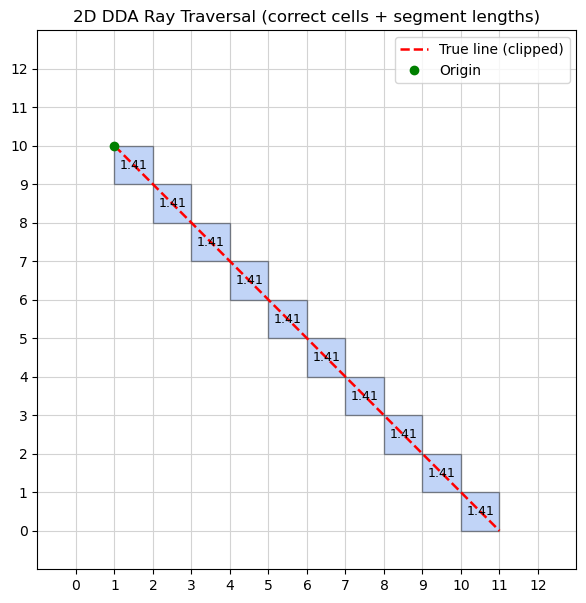

In [ ]:
bounds = (0, 12, 0, 12)
origin = (1., 10)
direction = (1., -1.)

demo_plot(origin, direction, bounds)